## **Inicio Proyecto**

**Configuración del ambiente**

In [ ]:
!python -V
print('------')
!pip show Pandas | grep 'Name\|Version'
print('------')
!pip show Numpy | grep 'Name\|Version'
print('------')
!pip show Matplotlib | grep 'Name\|Version'
print('------')
!pip show yfinance | grep 'Name\|Version'

**Importamos las librerias**

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
import json
import re
import datetime as dt
import yfinance as yf
from IPython.display import clear_output
import time

**Definición de variables globales**

In [1]:
global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision

## **Obtención de datos**

**Precio historico del bitcoin**

Definiremos la url de yahoo finance, luego definiremos la variable ua, que sera headers y contendra nuestro User Agent, definimos la variable r la cual se encargara de realizar la solicitud a la pagina web.

In [5]:
def importar_base_bitcoin():
  url = 'https://finance.yahoo.com/crypto'
  ua = {'User-Agente': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/117.0.0.0 Safari/537.36'}
  r = requests.get(url, headers= ua)
  # Extraer datos historicos del bitcoin, 7 días
  bitcoin = yf.Ticker("BTC-USD")
  historico = bitcoin.history(period='7d', interval="5m")
  return historico
df_bitcoin = importar_base_bitcoin()
df_bitcoin

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2023-10-15 00:00:00+00:00,26858.011719,26859.375000,26852.537109,26852.537109,0,0.0,0.0
2023-10-15 00:05:00+00:00,26846.734375,26849.812500,26846.007812,26849.812500,0,0.0,0.0
2023-10-15 00:10:00+00:00,26852.900391,26852.900391,26846.332031,26846.332031,0,0.0,0.0
2023-10-15 00:15:00+00:00,26846.289062,26849.716797,26846.289062,26849.716797,0,0.0,0.0
2023-10-15 00:20:00+00:00,26843.685547,26849.593750,26842.390625,26842.390625,0,0.0,0.0
...,...,...,...,...,...,...,...
2023-10-21 19:20:00+00:00,30104.060547,30106.347656,30072.722656,30072.722656,8903680,0.0,0.0
2023-10-21 19:25:00+00:00,30072.685547,30072.685547,30055.755859,30066.136719,27282432,0.0,0.0
2023-10-21 19:30:00+00:00,30069.599609,30080.160156,30069.599609,30073.115234,2161664,0.0,0.0


**Webscraping con beuatifulsoup para coinmarketcap para extraer el precio actual del Bitcoin BTC en dólares USD  y la tendencia.**

**Precio actual y la tendencia**

In [6]:
def extraer_tendencias():

  # Definimos las variables globales de nuevo
  global df_bitcoin, df_bitcoin_limpio, precio_actual, tendencia, media_bitcoin, algoritmo_decision
  # Definimos nuestro headers que contendra un diccionario con la clave User-Agent y de valor nuestro user agent extraido desde la web
  headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/117.0.0.0 Safari/537.36'}
  # Definimos la url que es el link de la pagina donde extramos el precio
  url = 'https://coinmarketcap.com/'
  # Envia un solicitud a la url y obtiene un repuesta que se guarda en la variable con el mismo nombre
  respuesta = requests.get(url, headers=headers)
  # Creamos un objeto BeautifulSoup con el contenido de la respuesta, con el cual podremos buscar en la base datos HTML
  s=BeautifulSoup(respuesta.content, features='lxml')
  # Busca todos los elementos <div> con la clases que hemos especificado, ya que el valor de la clase que contiene el precio varia entre 3 valores buscamos entre esos 3 valores.
  precios = s.findAll('div',{'class':['sc-a0353bbc-0 gDrtaY rise','sc-a0353bbc-0 gDrtaY','sc-a0353bbc-0 gDrtaY fall']})
  # Creamos una lista vacia donde almacenaremos los valores encontrados en precios
  precio=[]
  # Con este bucle for recorremos precios que es un objeto Beautifoulsoup y almacenamos cada valor dentro de la lista precios.
  for item in precios:
      precio.append(item.text.split())
  # Estamos escogiendo la lista que esta en la posición [0] y escogemos el primer elemento [0] que es el precio del bitcoin. remplazamos el simbolo $ y quitamos el espacio
  # luego remplazamos la coma quitando el espacio y nos queda un texto(string) que al ser un número lo convertiremos en flotante con float()
  precio_actual = float((precio[0][0]).replace("$", "").replace(",", ""))
  # Ahora hallaremos la tendencia. Primero busca todos los elementos <div> con la clases que hemos especificado, ya que el valor de la clase que contiene la tendencia varia entre 2
  # valores buscamos entre esos 2 valores.
  tendencias = s.findAll('span', {'class':['sc-d55c02b-0 gUnzUB','sc-d55c02b-0 iwhBxy']})
  # Dentro de la lista de valores tendencias, escogemos el primer elemento que contiene al bitcoin
  tendencia_bitcoin =  tendencias[0]
  # Ahora definimos la variable icon y dentro de ella estaremos buscando dentro de los elementos span todas las clases que coincidan con icon-Caret-down o icon-Caret-up.
  icono = tendencia_bitcoin.find('span', {'class': ['icon-Caret-down', 'icon-Caret-up']})
  # Ahora con el in, si icon-Caret-down en la clase es True retornara que la tendencia es a la baja caso contrario que es al alza
  if 'icon-Caret-down' in icono['class']:
      tendencia = 'La tendencia es a la baja'
  else:
      tendencia = 'La tendencia es al alza'
  print(f'El precio actual del bitcoin es: ${precio_actual} dólares')
  print(f'La tendencia actual es: {tendencia} ')
  return precio_actual, tendencia
#Desempaquetamos para que los valores que devuelve la función se almacenen en las variables que especficamos precio_actual y tendencia,
#de esta manera podemos hacer uso de ellas cuando querramos
precio_actual, tendencia = extraer_tendencias()

El precio actual del bitcoin es: $30138.1 dólares
La tendencia actual es: La tendencia es al alza 


## **Limpieza de datos**


Copia del df_bitcoin

In [7]:
df_bitcoin_copy = df_bitcoin.copy()
df_bitcoin_copy

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2023-10-15 00:00:00+00:00,26858.011719,26859.375000,26852.537109,26852.537109,0,0.0,0.0
2023-10-15 00:05:00+00:00,26846.734375,26849.812500,26846.007812,26849.812500,0,0.0,0.0
2023-10-15 00:10:00+00:00,26852.900391,26852.900391,26846.332031,26846.332031,0,0.0,0.0
2023-10-15 00:15:00+00:00,26846.289062,26849.716797,26846.289062,26849.716797,0,0.0,0.0
2023-10-15 00:20:00+00:00,26843.685547,26849.593750,26842.390625,26842.390625,0,0.0,0.0
...,...,...,...,...,...,...,...
2023-10-21 19:20:00+00:00,30104.060547,30106.347656,30072.722656,30072.722656,8903680,0.0,0.0
2023-10-21 19:25:00+00:00,30072.685547,30072.685547,30055.755859,30066.136719,27282432,0.0,0.0
2023-10-21 19:30:00+00:00,30069.599609,30080.160156,30069.599609,30073.115234,2161664,0.0,0.0


**Eliminando Valores duplicados en el indice(Datetime), verificando los valores nulos en la columana Close, encontrando los cuartiles Q1 y Q3, y la media del precio de cierre.**


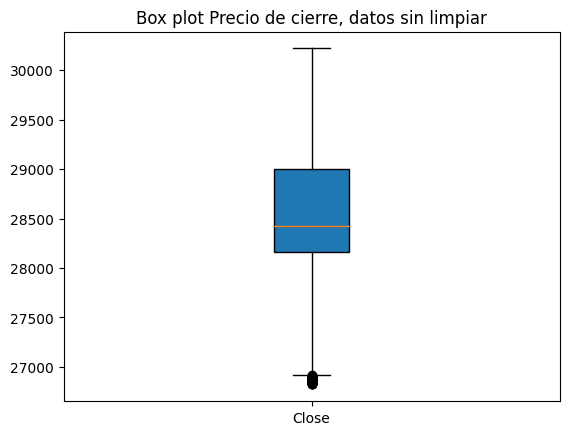

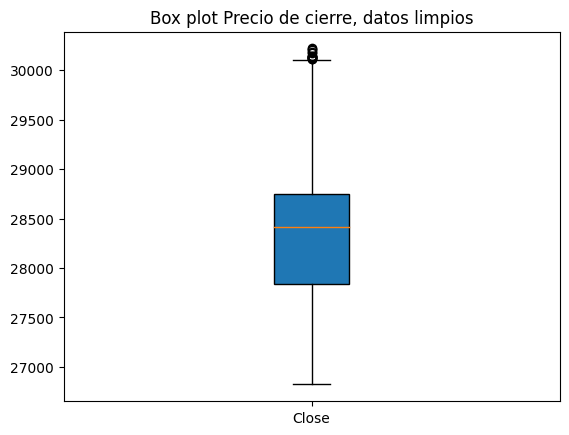

El precio promedio del bitcoin es: $28400.71 dólares


In [8]:
## Eliminando valores duplicados del indice si los hay, y elimannado las filas donde el valor de la columna close sea nulo o 0.
def limpieza_datos():
  # Aplicamos .duplicated para saber si hay duplicados.
  duplicados = df_bitcoin_copy.index.duplicated()
  # Contabilizamos la cantidad de duplicados que existen
  num_duplicados = duplicados.sum()
  # Ahora aplicaremos un condicional, donde si num_duplicados == 0 el df_limpio sera igual df_bitcoin_copy y sino será igual df_limpio = df_bitcoin_copy.index.drop_duplicates()
  # donde a el indice le estamos aplicando el metodo .drop_duplicates.
  if num_duplicados == 0:
    df_limpio = df_bitcoin_copy
  else:
    df_limpio = df_bitcoin_copy.index.drop_duplicates(inplace=True)
  # Ahora vamos analizar la columna close para determinar si hay valores nulos y de allí tomar una decisión de como tratarlos.
  valores_nan = df_limpio['Close'].isna()
  # Si en columnas no hay valores nulos, df_limpio_bitcoin = df_limpio y si hay valores nulos en la columna close tenemos dos opciones o eliminamos
  # los valores nulos con df_limpio_bitcoin = df_limpio.dropna(subset=['Close']) o sustituiremos con la media df_limpio_bitcoin = df_limpio.fillna(df_limpio['Close'].mean())
  if valores_nan is False:
    df_limpio_bitcoin = df_limpio
  else:
    df_limpio_bitcoin = df_limpio.fillna(df_limpio['Close'].mean())
  # Escogeremos todos las filas donde el valor de la columana Volume sea mayor a 0
  df_bitcoin_limpio = df_limpio_bitcoin[df_limpio_bitcoin['Volume'] > 0]
  # Haremos una grafica boxplot para los datos sin limpiar y otra para los datos
  # Gráfico sin limpiar los datos.
  #Sin limpiar los datos(Usaremos la copia del dataframe)
  plt.boxplot(df_bitcoin_copy['Close'], patch_artist=True, labels=['Close'])
  plt.title("Box plot Precio de cierre, datos sin limpiar")
  plt.show()
  #Luego de limpiar los datos (Usaremos el dataframe limpio).
  plt.boxplot(df_bitcoin_limpio['Close'], patch_artist=True, labels=['Close'])
  plt.title("Box plot Precio de cierre, datos limpios")
  plt.show()
  #Calcularemos los q1,q3, el rango intercuantilico(IQR) y los con esto primero podemos ver cuales datos
  Q1 = df_bitcoin_limpio['Close'].quantile(0.25)
  Q3= df_bitcoin_limpio['Close'].quantile(0.75)
  IQR = Q3 - Q1
  # Ahora procedemos hallar el maxímo y el minimo del precio de cierre
  maximo=df_bitcoin_limpio['Close'].max()
  min=df_bitcoin_limpio['Close'].min()
  # Calcularemos ahora cual es el rango que corresponde a los valores de datos normales, es decir no atipicos. Estaremos calculando los Outliners.
  # Todos lo valores por debajo de Q1-1.5*IQR y por encima de Q3+1.5*IQR son valores outliners si nuestro maximo=df_bitcoin_limpio['Close'].max() es mayor que Q3+1.5*IQR y
  # si nuestro min=df_bitcoin_limpio['Close'].min() es menor a Q1-1.5*IQR sabremos que tenemos datos atipicos
  no_outliners = '[Q1-1.5*IQR,Q3+1.5*IQR]:',[Q1-1.5*IQR,Q3+1.5*IQR]
  no_outliners
  # Para evitar trabajar con datos atipicos y que nuestra información este lo mas limpia posible filtraremos los valores del dataframe para que esten entre el Q1 y Q3
  df_bitcoin_filtrado =  df_bitcoin_limpio[(df_bitcoin_limpio['Close']>= Q1 ) & (df_bitcoin_limpio ['Close']<= Q3)]
  # Por ultimo hallaremos la media del precio de cierre del bitcoin, para esto usamos el dataframe: df_bitcoin_filtrado
  media_bitcoin = df_bitcoin_filtrado['Close'].mean().round(2)
  print(f'El precio promedio del bitcoin es: ${media_bitcoin} dólares')
  return df_bitcoin_filtrado, media_bitcoin
#Desempaquetamos para que los valores que devuelve la función se almacenen en las variables que especficamos df_bitcoin_filtrado y media_bitcoin,
#de esta manera podemos hacer uso de ellas cuando querramos
df_bitcoin_filtrado, media_bitcoin = limpieza_datos()

## Toma de decisiones

In [9]:
# Vamos a crear la función tomar_decisiones()
def tomar_decisiones():
  # Definimos una vez mas las variables globales
  global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision
  # Creamos la variable algoritmo_decision la cual estara vacia y se rellenara con un string
  decision = ''
  #Creamos el codigo para la toma de decisiones
  if precio_actual >= media_bitcoin and tendencia == 'La tendencia es a la baja':
    #Si cumplen las condiciones establecidas la variable
    decision = 'Vender'
  elif precio_actual <= media_bitcoin and tendencia == 'La tendencia es al alza':
    decision = 'Comprar'
  else:
    decision = 'Espera'
  return decision
# A la variable algoritmo_decision le asignamos la función tomar_decisiones() para que el valor al ejecutar la función se guarde en la varible.
algoritmo_decision = tomar_decisiones()

## Visualización

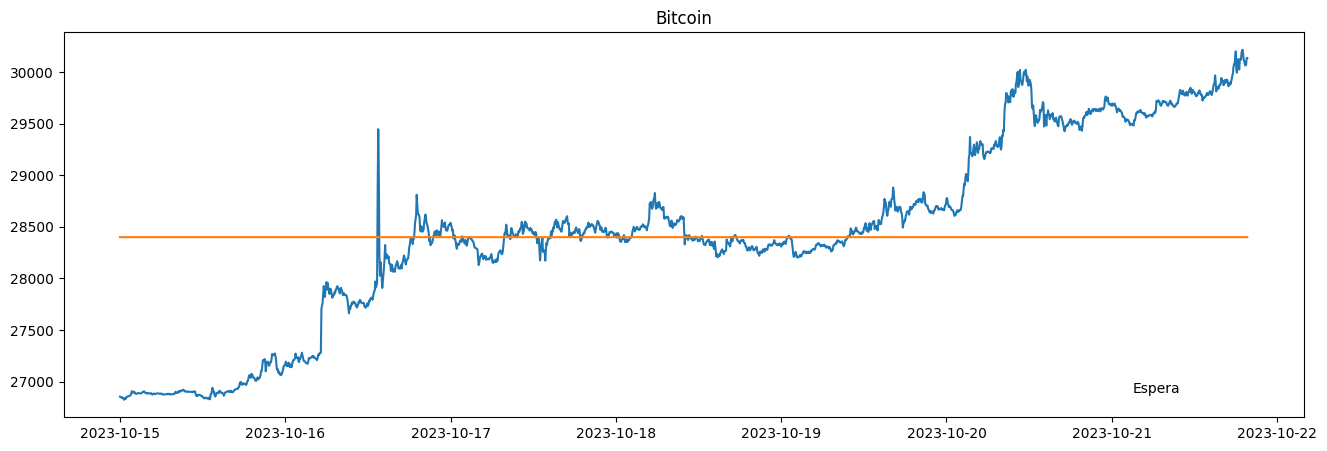

In [11]:
#Crearemos la función visualizacion() dentro
def visualizacion():
  # Definimos una vez mas las variables globales
  global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision
  #añadiremos el promedio como columana del data frame
  df_bitcoin['Promedio'] = media_bitcoin
  #Gráfico, primero vamos a configurar el tamaño
  plt.rc('figure',figsize = (16,5))
  #Colocaremos un titulo al grafico
  plt.title('Bitcoin')
  #Gráfico primero definiremos la variable y que será el eje y representa al precio de cierre, luego x, que representa x que sería el eje x y z que será la lína que representa  al promedio
  #el cúal estaremos añadiendo a la grafica.
  y = df_bitcoin['Close']
  x = df_bitcoin.index
  z = df_bitcoin['Promedio']
  #Con .plot crearemos primeramente la grafica con x y y, luego a la grafica le añadiremos z volviendo usar .plot
  grafico = plt.plot(x, y)
  grafico_actualizado = plt.plot(x,z)
  # Añadiremos un mensaje a la grafica con la decisión usando el método .annotate()
  x_text = x[-200] # índice indicado para x
  y_text = y[50]   # índice indicado para y
  plt.annotate(algoritmo_decision, xy=(x_text, y_text))
  plt.show()
visualizacion()

## **Automatización**

El precio actual del bitcoin es: $30138.64 dólares
La tendencia actual es: La tendencia es al alza 


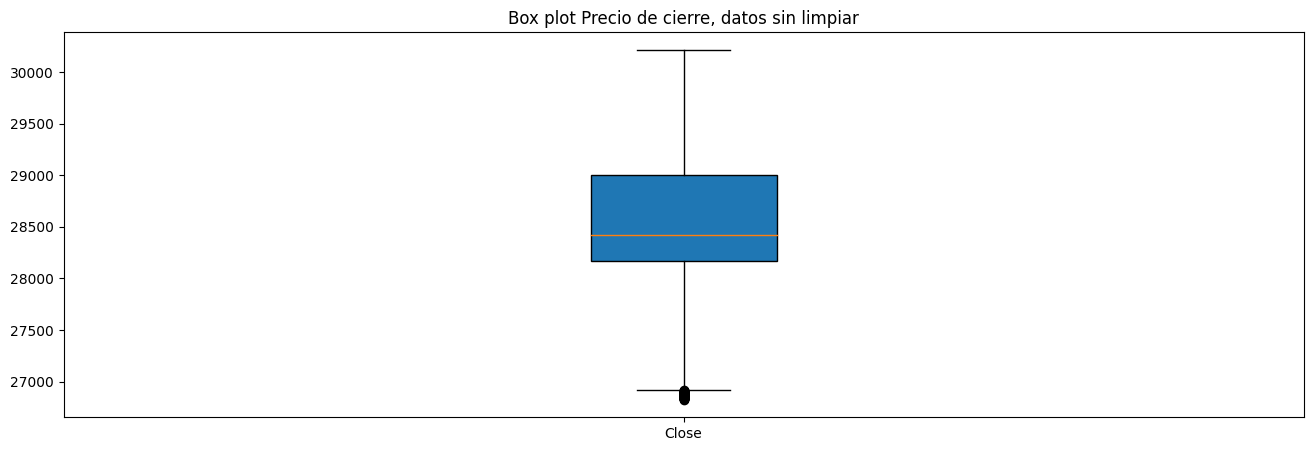

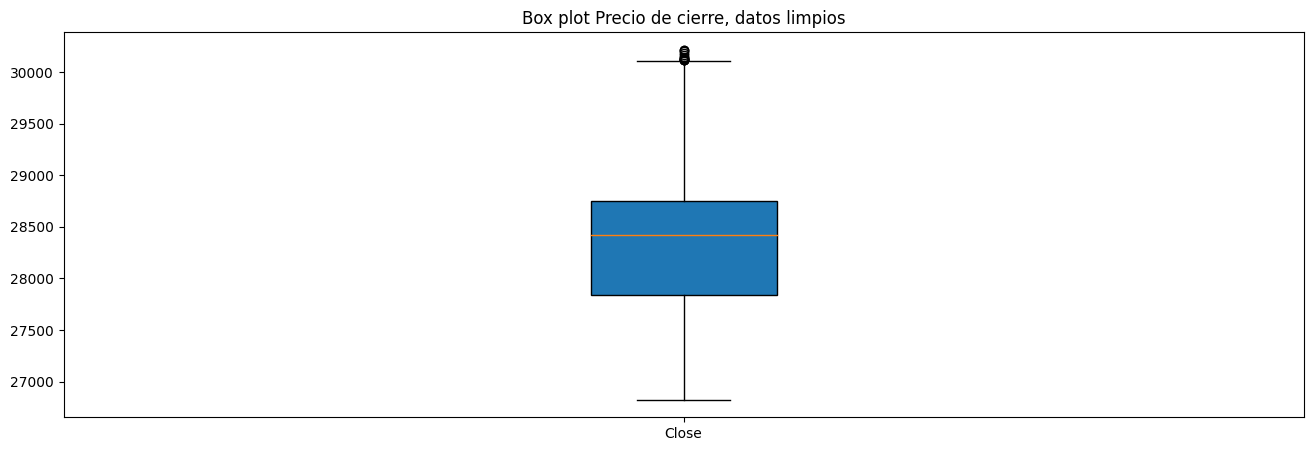

El precio promedio del bitcoin es: $28400.71 dólares


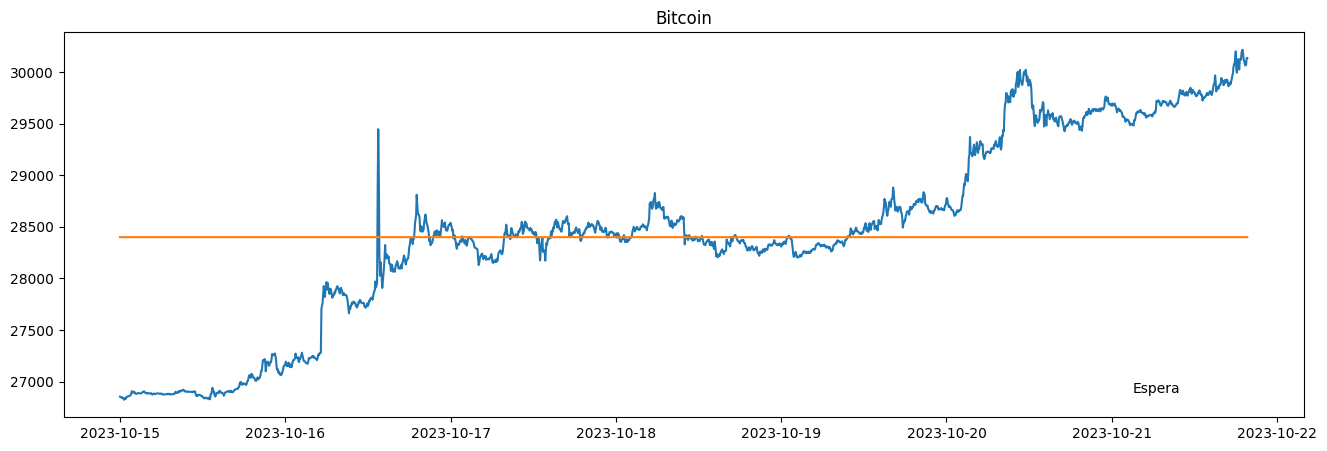

In [12]:
while(True):
  #Este método (clear_output()) nos permite borrar los resultados de la pantalla antes de imprimir un nuevo gráfico, y así evitar tener más de un gráfico en la pantalla
  clear_output()
  importar_base_bitcoin()
  extraer_tendencias()
  limpieza_datos()
  tomar_decisiones()
  visualizacion()
  time.sleep(300)